In [1]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

import django
django.setup()

import os
from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest
from sklearn.metrics import cohen_kappa_score
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
available_dbs = settings.DATABASES.keys()[1:]
PLOTS_PATH = 'Analysis/plots/'
PLOTS_FORMATS = ['.pdf', '.png']

In [2]:
shared_questions = {
        'webapps': [87766L, 26903L, 62617L,
            35474L, 41781L, 22823L,
            21256L, 22647L, 54023L,
            89446L, 35777L, 18961L,
            8300L, 4636L, 9933L,
            79077L, 6114L, 33351L,
            48644L, 95441L, 86540L,
            965L, 70948L, 49595L,
            23029L, 60268L, 10071L,
            39636L, 41275L, 93269L,
            87742L, 22719L, 45530L
        ],
        'travel': [31336L, 46022L, 50155L,
            67830L, 47607L, 57198L,
            3677L, 19143L, 23420L,
            6258L, 7733L, 22628L,
            51218L, 30406L, 30744L,
            17830L, 21846L, 73300L,
            49599L, 13845L, 13279L,
            31394L, 77483L, 51459L,
            46329L, 55678L, 66741L,
            61532L, 19214L, 2589L,
            25204L, 21901L, 17942L
        ],
        'cooking': [45214L, 1927L, 19040L,
            15970L, 54327L, 47570L,
            65309L, 6837L, 28760L,
            2425L, 15681L, 35629L,
            2079L, 14364L, 38188L,
            15794L, 42120L, 58902L,
            403L, 58713L, 49975L,
            22725L, 11411L, 69203L,
            22513L, 7227L, 7491L,
            62409L, 43000L, 58797L,
            53908L, 37637L, 71194L
        ]
    }

# Cohen's Kappa score, for each db

In [24]:
# keys: available_dbs
# values: pandas DataFrame with paired Cohens' kappa scores
kappas = {}

for db in available_dbs:
    os.write(1, '\n************************\n{}\n************************\n'.format(db))
    question_id_list = shared_questions[db]
    
    # get all shared questions
    questions = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .filter(id__in=question_id_list)
    
    # to be filled with a very long list of annotations
    data = {
        'enrico' : [],
        'marit' : [],
        'henrik': [],
        'christine': []
    }    
    
    # for each thread
    for question in questions:
        
        # fill with annotations in the format [question.annt + answers.annot]
        thread_data = {}
        
        answers = Posts.objects\
            .using(db)\
            .filter(parentid=question.id)\
            .filter(posttypeid=2)
        
        thread_data['enrico'] = [question.annotatedqualityenrico] + \
                         [answer.annotatedqualityenrico for answer in answers]
        
        thread_data['marit'] = [question.annotatedqualitymarit] + \
                         [answer.annotatedqualitymarit for answer in answers]
        
        thread_data['christine'] = [question.annotatedqualitychristine] + \
                         [answer.annotatedqualitychristine for answer in answers]
        
        thread_data['henrik'] = [question.annotatedqualityhenrik] + \
                         [answer.annotatedqualityhenrik for answer in answers]
        
        # consistency check: retrived same amout of annotations
        expected_len = len(thread_data['enrico'])
        if len(thread_data['marit']) != expected_len or \
            len(thread_data['christine']) != expected_len or \
                len(thread_data['henrik']) != expected_len:
            os.write(1, "WARN\n")
   
        
        # append to user's annotations
        data['enrico'] += thread_data['enrico']
        data['marit'] += thread_data['marit']
        data['christine'] += thread_data['christine']
        data['henrik'] += thread_data['henrik']
    
    
    # columns are users's annotations
    # NOTE: -1 means 'dont know', NaN means missing value (not even annotated)
    data_df = pd.DataFrame.from_dict(data)
    
    # check for NaNs
    #os.write(1, '{}\n'.format(data_df.isnull().count()))
    
    

    # tear down -1 (Don't know values --> NaN)
    data_df_filtered = data_df.replace(-1, np.NaN)
    
    # drop all NaNs rows
    data_df_filtered = data_df_filtered.dropna(axis='index')
    
    os.write(1, 'Filtered:\t{} over {}; Excluded ratio: {:.2f}%\n------------------\n'.format(data_df_filtered.size, 
                                                                        data_df.size, 
                                                                        (data_df.size - data_df_filtered.size) / float(data_df.size) * 100))
    
    for key in data.keys():
        os.write(1, '{}\n'.format(data_df[key].value_counts(dropna=False, sort=False)))

    
    # paired users' kappa scores
    kappa_df = pd.DataFrame(np.nan, index=data.keys(), columns=data.keys())
    
    
    for ann1, ann2 in itertools.permutations(data.keys(), 2):
        # fill the table
        kappa_df.loc[ann1,ann2] = cohen_kappa_score(data_df_filtered[ann1], data_df_filtered[ann2], labels=[0,1,2])
        
    kappas[db] = kappa_df

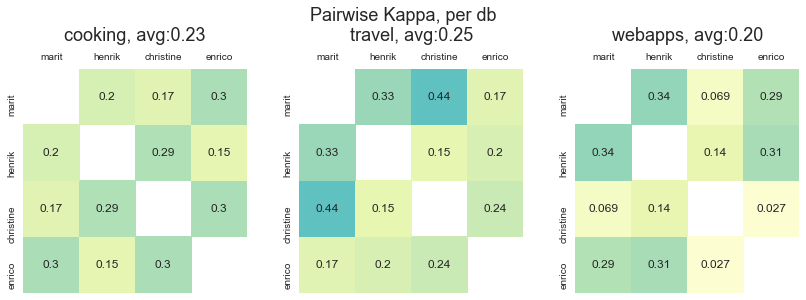

In [94]:
y_offset = 1.1

fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pairwise Kappa, per db", fontsize=18)

ax1 = fig.add_subplot(131)
sns.heatmap(kappas['cooking'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax1, square=True, cbar=False)
ax1.xaxis.tick_top()
plt.title('cooking, avg:{0:.2f}'.format(kappas['cooking'].mean().mean()), fontsize=18, y=y_offset)


ax2 = fig.add_subplot(132)
sns.heatmap(kappas['travel'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax2, square=True, cbar=False)
ax2.xaxis.tick_top()
plt.title('travel, avg:{0:.2f}'.format(kappas['travel'].mean().mean()), fontsize=18, y=y_offset)

ax3 = fig.add_subplot(133)
sns.heatmap(kappas['webapps'], annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=ax3, square=True, cbar=False)
ax3.xaxis.tick_top()
plt.title('webapps, avg:{0:.2f}'.format(kappas['webapps'].mean().mean()), fontsize=18, y=y_offset)

plt.tight_layout(pad=3)

for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'kappa_stats' + plot_format)

# Annotations for each thread

In [5]:
k = {}

ts_ = {}

for db in available_dbs:
    question_id_list = shared_questions[db]
    
    questions = Posts.objects\
    .using(db)\
    .filter(posttypeid=1)\
    .filter(id__in=question_id_list)

    ts = {}

    data = {
        'enrico' : [],
        'marit' : [],
        'henrik': [],
        'christine': []
    }    
    for question in questions:
        
        thread_data = {}
        
        answers = Posts.objects\
            .using(db)\
            .filter(parentid=question.id)\
            .filter(posttypeid=2)
        
        thread_data['enrico'] = [question.annotatedqualityenrico] + \
                         [answer.annotatedqualityenrico for answer in answers]
        
        thread_data['marit'] = [question.annotatedqualitymarit] + \
                         [answer.annotatedqualitymarit for answer in answers]
        
        thread_data['christine'] = [question.annotatedqualitychristine] + \
                         [answer.annotatedqualitychristine for answer in answers]
        
        thread_data['henrik'] = [question.annotatedqualityhenrik] + \
                         [answer.annotatedqualityhenrik for answer in answers]
        
        ts[question.id] = thread_data
        

        
    ts_[db] = ts
        

print ts_

{'webapps': {48644L: {'marit': [-1, -1], 'henrik': [1, 0], 'christine': [2, 2], 'enrico': [1, 2]}, 54023L: {'marit': [-1, -1, -1, -1, -1], 'henrik': [-1, -1, -1, -1, -1], 'christine': [1, 2, 1, 2, 0], 'enrico': [1, 2, 1, 2, 0]}, 21256L: {'marit': [1, 2], 'henrik': [2, 2], 'christine': [2, 2], 'enrico': [2, 2]}, 60268L: {'marit': [2, 1, 2], 'henrik': [2, 1, 0], 'christine': [1, 2, 2], 'enrico': [2, 2, 2]}, 86540L: {'marit': [-1, -1], 'henrik': [2, 1], 'christine': [1, 1], 'enrico': [0, 0]}, 18961L: {'marit': [2, 2], 'henrik': [2, 2], 'christine': [2, 2], 'enrico': [2, 2]}, 35474L: {'marit': [-1, -1, -1], 'henrik': [2, 1, 2], 'christine': [-1, 2, 2], 'enrico': [2, 2, 1]}, 26903L: {'marit': [2, 2, 1, 1], 'henrik': [2, 2, 2, 1], 'christine': [2, 2, 2, 1], 'enrico': [2, 2, 2, 2]}, 62617L: {'marit': [1, 0, 1], 'henrik': [2, 1, 1], 'christine': [2, 1, 2], 'enrico': [1, 1, 2]}, 4636L: {'marit': [1, 1, 1], 'henrik': [1, 1, 1], 'christine': [1, 1, 2], 'enrico': [0, 1, 1]}, 70948L: {'marit': [2, 